# Evaluation

**Bourgeois Elisabeth**

## Problématique 

Prédire la classe d'une voiture sachant que : 
- Classe 1 : MPG < 18
- Classe 2 : 18 <= MPG < 24
- Classe 3 : 24 <= MPG < 30
- Classe 4 : MPG >= 30


## Etape n°0 - Initialisation des données

Visualisez les données pour en tirer des conclusions. Commentez les résultats. 

Exemples : nombres de valeurs manquantes, représentation des classes, types de données, ...

Prélude et chargemnent des données

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import statsmodels as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [313]:
# chargement des données
car_data = pd.read_csv('/home/liz/Documents/MS_Big_Data_TP_et_projets/Management_des_ressources/car_performance.csv',index_col='name')
# 1ère visu
car_data.head(10)


,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
name,,,,,,,,
volvo 245,European,76,20.0,4,130.0,102.0,3150,15.7
amc matador,American,76,15.5,8,304.0,120.0,3962,13.9
amc hornet sportabout (sw),American,71,18.0,6,258.0,110.0,2962,13.5
amc hornet,American,73,18.0,6,232.0,100.0,2945,16.0
vw dasher (diesel),European,80,43.4,4,90.0,48.0,2335,23.7
chevrolet monte carlo s,American,73,15.0,8,350.0,145.0,4082,13.0
volvo 145e (sw),European,72,18.0,4,121.0,112.0,2933,14.5
amc matador (sw),American,74,14.0,8,304.0,150.0,4257,15.5
ford mustang,American,71,18.0,6,250.0,88.0,3139,14.5


Taille et type du jeu de données

In [314]:
# nb d'individus, d'attributs, et de valeurs dans le dataset
print('Structure du jeu de données :', len(car_data.axes[0]), 'lignes et ',len(car_data.axes[1]),' colonnes dans ce dataset, contenant au total ', car_data.size,' valeurs.\n')
# types des attributs du jeu de données
print('Types des attributs du jeu de données :\n', car_data.dtypes)

Structure du jeu de données : 406 lignes et  8  colonnes dans ce dataset, contenant au total  3248  valeurs.

Types des attributs du jeu de données :
 origin           object
year              int64
mpg             float64
cylinders         int64
engine          float64
horsepower      float64
weight            int64
acceleration    float64
dtype: object


In [315]:
# origine est de type object, regardons toutes les valeurs possibles pour cet attributs
car_data.origin.unique()

array(['European', 'American', 'Japanese'], dtype=object)

In [316]:
# je convertis le type de l'attirbut origin en chaînes de caractères pr en faciliter son traitement plus tard
car_data.origin = car_data.origin.astype('string')

## Etape n°1 : Exploration des données 


In [317]:
# statistiques sommaires du jeu de données
display(car_data.describe())
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

,year,mpg,cylinders,engine,horsepower,weight,acceleration
count,406.000000,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000
mean,75.921182,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704
std,3.748737,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359
min,70.000000,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,73.000000,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000
50%,76.000000,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000
75%,79.000000,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000
max,82.000000,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000


Analyse descriptive univariée

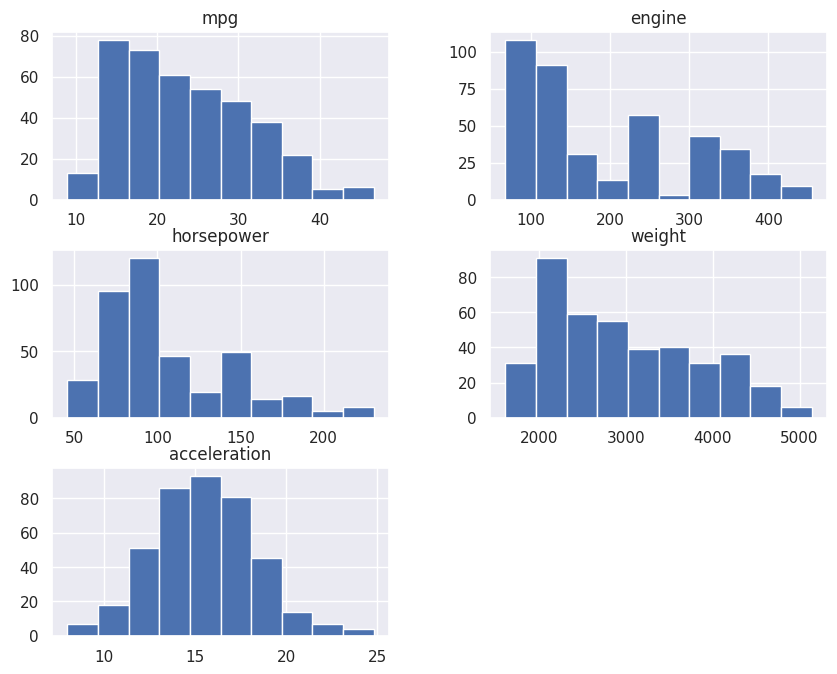

In [318]:
# distribution des attributs à valeurs continues
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10, 8)
car_data[["mpg", "engine", "horsepower", "weight", "acceleration"]].hist()
plt.show()


In [265]:
# Les histogrammes ci-dessus nous confèrent les informations suivantes : 
# L'accéleration suit une distribution normale, et la plupart des voitures ont une accélération de 15m/s2
# Plus de la moitié des véhicules ont 4 cylindres
# La variable à prédire est légèrement plus dense vers la gauche
# Les attributs n'ont pas le même ordre de grandeur (prévoir donc normalisation d'elles)

In [319]:
# distribution de l'attribut cylinders : nous avons entre 3 et 8 cylindres par voiture (variable discrète)
cylinders_count=car_data['cylinders'].value_counts().sort_values(ascending=False)
cylinders_count

4    207
8    108
6     84
3      4
5      3
Name: cylinders, dtype: int64

Text(0.5, 1.0, 'car cylinders')

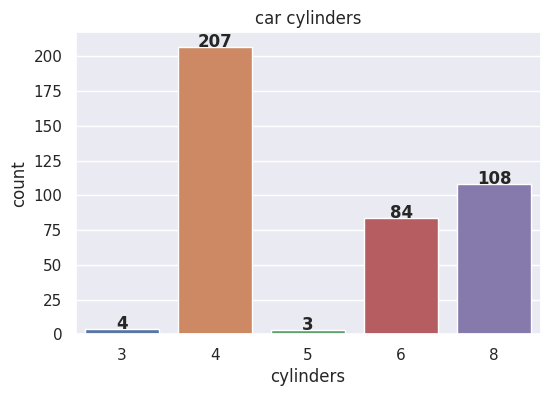

In [321]:
# illustration de la distribution de cylinders
# il n'y a pas de véhicules à 7 cylindres, la cylindrée la plus courante est 4. 
plt.figure(figsize=(6,4))
axes = sns.countplot(data=car_data,x='cylinders')
for patch in axes.patches:
    loc = patch.get_x()
    width = patch.get_width()
    height = patch.get_height()
    axes.text(loc+width/2, height, str(height), fontsize=12, weight='bold', ha='center')

plt.xlabel('cylinders',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.title('car cylinders',fontsize=12)


Visualisation des valeurs nulles et aberrantes

In [322]:
#La méthode sum() permet de connaître le nombre de valeurs nulles dans notre DataFrame
# on détecte alors le nb de valeurs nulles pr chaque attribut
print(car_data.isnull().sum())


origin          0
year            0
mpg             8
cylinders       0
engine          0
horsepower      6
weight          0
acceleration    0
dtype: int64


In [323]:
# on observe les lignes pour lesquelles nous avons trouvé des valeurs nulles   
print('individus où le mpg est nul : \n', car_data[pd.isnull(car_data["mpg"])],'\n'  )
print('individus où le horsepower est nul : \n', car_data[pd.isnull(car_data["horsepower"])],'\n'  )

individus où le mpg est nul : 
                                     origin  year  mpg  cylinders  engine  \
name                                                                       
ford torino (sw)                  American    70  NaN          8   351.0   
chevrolet chevelle concours (sw)  American    70  NaN          8   350.0   
amc rebel sst (sw)                American    70  NaN          8   360.0   
saab 900s                         European    81  NaN          4   121.0   
plymouth satellite (sw)           American    70  NaN          8   383.0   
volkswagen super beetle 117       European    71  NaN          4    97.0   
ford mustang boss 302             American    70  NaN          8   302.0   
citroen ds-21 pallas              European    70  NaN          4   133.0   

                                  horsepower  weight  acceleration  
name                                                                
ford torino (sw)                       153.0    4034          11.0  


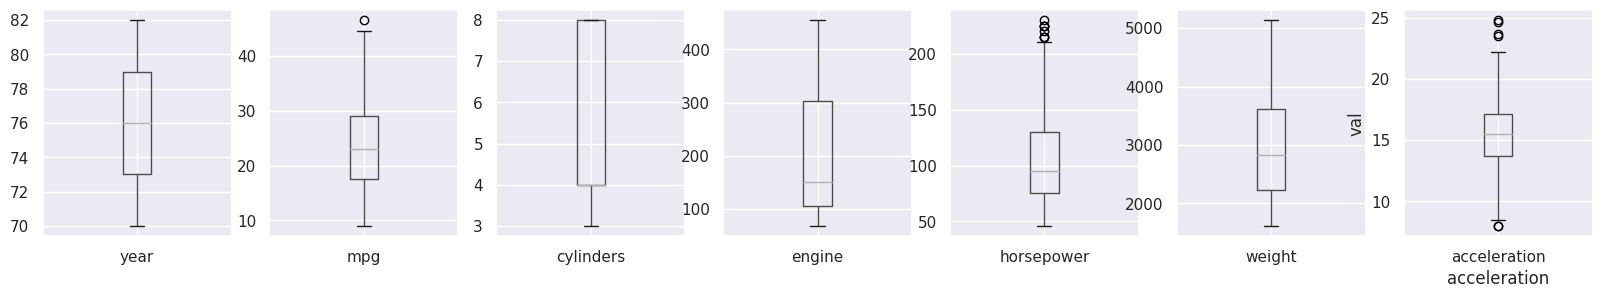

In [325]:
# Existe-t-il des outliers ? 

# définition d'une routine pour affichage d'une boîte de turkey
def dfboxplot(df, listvars):
    fig,axes=plt.subplots(nrows=1,ncols=len(listvars),figsize=(20,3))
    counter=0
    for ax in axes:
        df.boxplot(column=listvars[counter], ax=axes[counter])
        plt.ylabel('val')
        plt.xlabel(listvars[counter])
        counter = counter+1
    plt.show()

# Création d'une liste des attributs aux valeurs continues
linear_vars = car_data.select_dtypes(include=[np.number]).columns

# appel de la fct d'affichage, uniquement pr les attributs aux valeurs continues
dfboxplot(car_data, linear_vars)

# On voit quelques valeurs "exceptionnelles" pour mpg, plus nombreuses pour horsepower et pour l'accélération que l'on pourra éventuellement supprimer

Analyse descriptive bivariée

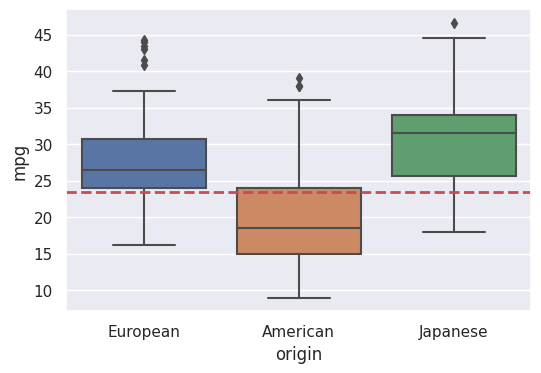

In [326]:
# Relation mpg/origin : ces boîtes de Turkey permettent de constater que les véhicules américaines sont moins efficaces au regard de leur consommation (mpg)
sns.set()
fig, ax = plt.subplots(figsize=(6, 4))
fig = sns.boxplot(x='origin', y="mpg", data=car_data)
plt.axhline(org.mpg.mean(),color='r',linestyle='dashed',linewidth=2)
plt.show()

Text(0, 0.5, 'MPG')

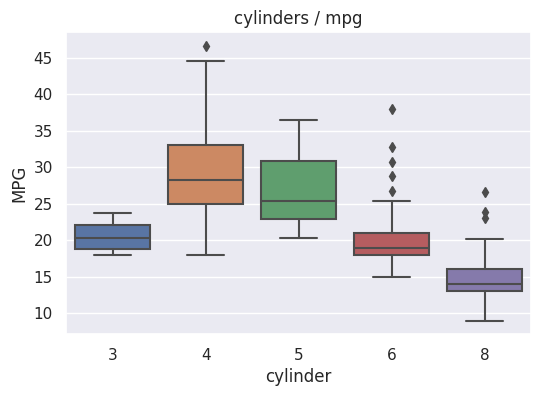

In [327]:
# Etude de la relation entre cylinders et mpg 

# # est-ce que le mpg peut être prédit par la cylindrée du véhicule ? Etude du lien entre ces deux attributs
plt.figure(figsize=(6,4))
sns.boxplot(data=car_data , x='cylinders',y='mpg');
plt.title('cylinders / mpg',fontsize=12)
plt.xlabel('cylinder',fontsize=12)
plt.ylabel('MPG',fontsize=12)
# on observe que pour une cylindrée de 4, le mpg avoisine les 27, ce qui est la meilleure moyenne obtenue parmi les cylindrées rencontrées


Text(0.5, 1.0, 'relation entre taille du moteur et conso')

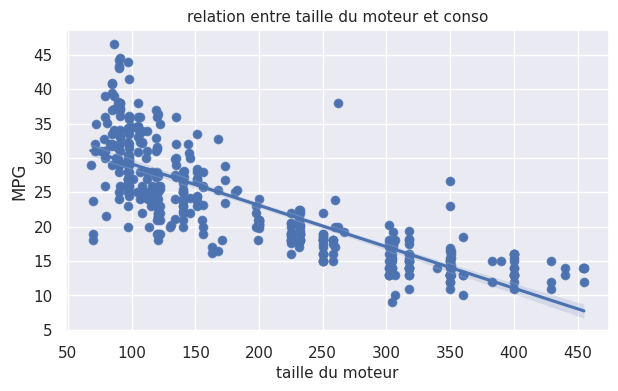

In [329]:
# Etude de la relation entre la taille du moteur et la consommation mpg  (valeurs numériques d'où scatterplot)
# On observe que ces 2 attributs sont négativement corréls : plus le moteur est gros, plus la conso est importante
plt.figure(figsize=(7,4))
sns.scatterplot(data=car_data,x='engine',y='mpg')
sns.regplot(data=car_data,x='engine',y='mpg')
plt.xlabel('taille du moteur',fontsize=11)
plt.ylabel('MPG',fontsize=12)
plt.title('relation entre taille du moteur et conso',fontsize=11)


Text(0.5, 1.0, 'taille du moteur par nb de cylindres')

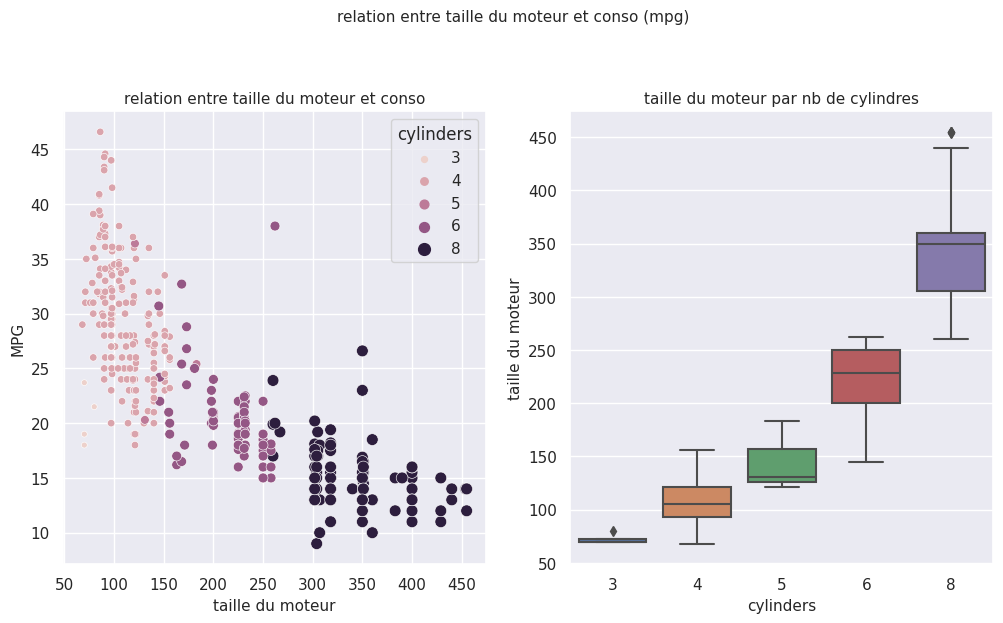

In [330]:
# pour aller plus loin, on va distinguer les véhicules par cylindrées dans la représetnation de la relation entre la taille du moteur et la conso
# On observe que les petites tailles de moteur ne concernent que les véhicules avec une cylindrée <=4, et que leur conso est bien plus convenable
# Plus la cylindrée augmente, plus la taille du moteur également, et la consommation aussi, ce qui est cohérent avec le fait qu'une plus grosse 
# cylindrée nécessite de facto un moteur de plus grande taille. 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.suptitle('relation entre taille du moteur et conso (mpg)',fontsize=11,y=1.05)
sns.scatterplot(data=car_data,x='engine',y='mpg',hue='cylinders',size='cylinders')
plt.xlabel('taille du moteur',fontsize=11)
plt.ylabel('MPG',fontsize=11)
plt.title('relation entre taille du moteur et conso',fontsize=11)
plt.subplot(1,2,2)
sns.boxplot(data=car_data,x='cylinders',y='engine')
plt.ylabel('taille du moteur',fontsize=11)
plt.xlabel('cylinders',fontsize=11)
plt.title('taille du moteur par nb de cylindres',fontsize=11)

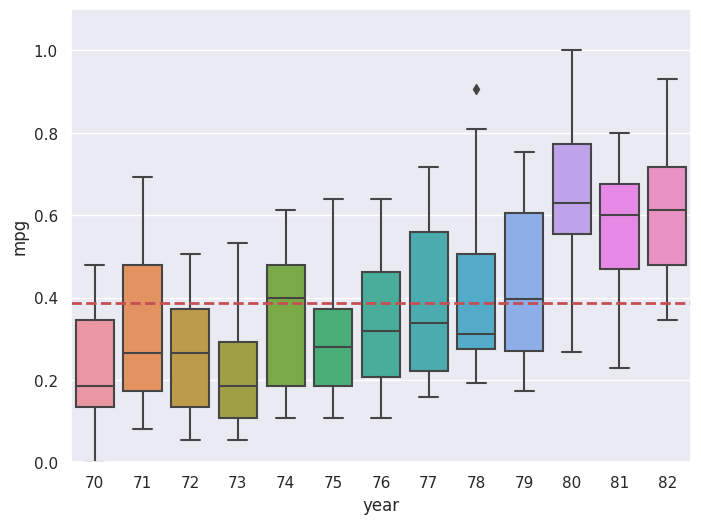

In [331]:
# Distribution de mpg selon l'année

# On observe que les voitures consomment globalement moins au fur et à mesure qu'elles sont plus récentes, mais la tendance n'est vraiment pas franche. 
var = 'year'
data_plt = pd.concat([car_data_scale['mpg'], car_data_scale[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="mpg", data=data_plt)
fig.axis(ymin=0, ymax=1.1)
plt.axhline(car_data_scale.mpg.mean(),color='r',linestyle='dashed',linewidth=2)

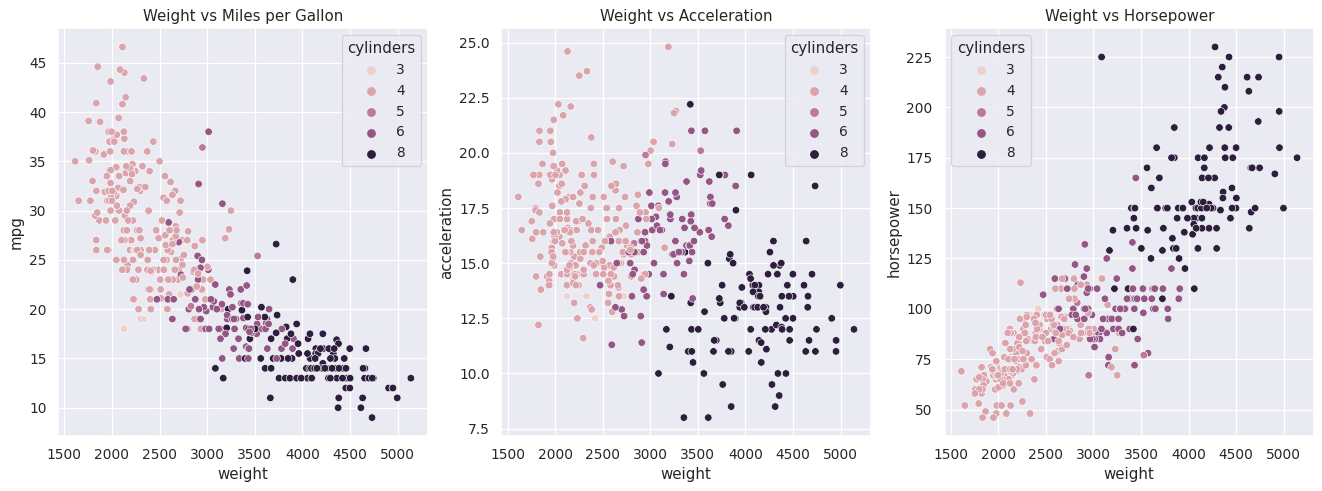

In [332]:
# D'autres relations : 

fig, axes = plt.subplots(figsize=(18, 6), nrows=1, ncols=3, dpi=90)

# poids et consommation
# les véhicules lourds consomment plus
sns.scatterplot(x="weight", y="mpg", data=car_data, hue="cylinders", ax=axes[0])
axes[0].set_title("Weight vs Miles per Gallon")

# poids et accélération
# les véhicules lourds accélèrent moins
sns.scatterplot(x="weight", y="acceleration", data=car_data, hue="cylinders", ax=axes[1])
axes[1].set_title("Weight vs Acceleration")

# poids et puissance
# les véhicules lourds sont de plus grande puissance
sns.scatterplot(x="weight", y="horsepower", data=car_data, hue="cylinders", ax=axes[2])
axes[2].set_title("Weight vs Horsepower")

plt.show()

## Etape n°2 - Nettoyage et préparation des données

Gestion des valeurs manquantes

In [333]:
# pour les valeurs de l'attribut mpg nulles, vu la taille du dataset, nous décidons de supprimer ces lignes-là.
indexnames = car_data[pd.isnull(car_data["mpg"])].index
car_data.drop(axis=0,index=indexnames,inplace=True)

# pour les valeurs de l'attribut horsepower nulles, nous les remplaçons par la médiane des valeurs de cet attribut
median = car_data['horsepower'].median()
car_data['horsepower'].fillna(median, inplace=True)

# on vérifie que le nettoyage des données est terminé
print('Il reste ',car_data.isnull().sum().sum(),' valeur(s) nulle(s).\n')

Il reste  0  valeur(s) nulle(s).



Gestion des outliers

In [334]:
# Suppression des éventuels outliers

# fct de suppression des outliers à partir d'un certain seuil du z-score
def removeoutliers(df, listvars, z):
    from scipy import stats
    for var in listvars:
        df1 = df[np.abs(stats.zscore(df[var])) < z]
    return df1

# On fixe un seuil de z-score à 3
car_data = removeoutliers(car_data, linear_vars,3)

Gestion des "erreurs de frappe"

In [335]:
# on remarque que des noms de véhicules suivent des schémas réguliers. Nous allons en profiter pour extraire la marque du constructeur, qui, potentiellement, pourrait ajouter
# une information supplémentaire qui améliorerait notre modèle de prédiction, s'il advenait que la marque contribuait à la prédictabilité de la mpg
car_data.index

Index(['volvo 245', 'amc matador', 'amc hornet sportabout (sw)', 'amc hornet',
       'vw dasher (diesel)', 'chevrolet monte carlo s', 'volvo 145e (sw)',
       'amc matador (sw)', 'ford mustang', 'dodge aries wagon (sw)',
       ...
       'volkswagen rabbit', 'amc gremlin', 'ford fairmont',
       'buick regal sport coupe (turbo)', 'ford pinto', 'subaru',
       'toyota corolla 1600 (sw)', 'oldsmobile cutlass ls', 'plymouth sapporo',
       'chevrolet malibu'],
      dtype='object', name='name', length=395)

In [336]:
# nettoyage des noms de marque stockés pour pouvoir en faire des classes
car_data.index
car_data[car_data.index.str.contains('subaru')].index.str.replace('(.*)', 'subaru dl')
car_data['Marque'] = car_data.index.str.extract('([A-Za-z]+)\s', expand=False)  # extraction par expression régulière et stockage dans le dataset 
car_data['Marque'] = car_data['Marque'].replace(['volkswagen','vokswagen','vw'],'VW')
car_data['Marque'] = car_data['Marque'].replace(['mazada','maxda'],'mazda')
car_data['Marque'] = car_data['Marque'].replace('toyouta','toyota')
car_data['Marque'] = car_data['Marque'].replace('citroen','peugeot')
car_data['Marque'] = car_data['Marque'].replace(['benz','mercedes'],'mercedes-benz')
car_data['Marque'] = car_data['Marque'].replace('nissan','datsun')
car_data['Marque'] = car_data['Marque'].replace('capri','ford')
car_data['Marque'] = car_data['Marque'].replace(['chevroelt','chevy'],'chevrolet')
car_data['Marque'].fillna(value = 'subaru',inplace=True)

# stat sur les marques de nos individus
car_data['Marque'].value_counts(normalize=True)

ford             0.131646
chevrolet        0.116456
plymouth         0.078481
dodge            0.070886
amc              0.070886
toyota           0.065823
datsun           0.060759
VW               0.053165
buick            0.043038
pontiac          0.040506
honda            0.032911
mazda            0.030380
mercury          0.027848
oldsmobile       0.025316
fiat             0.020253
audi             0.017722
peugeot          0.017722
chrysler         0.015190
volvo            0.015190
renault          0.012658
subaru           0.010127
saab             0.010127
opel             0.010127
mercedes-benz    0.007595
cadillac         0.005063
bmw              0.005063
hi               0.002532
triumph          0.002532
Name: Marque, dtype: float64

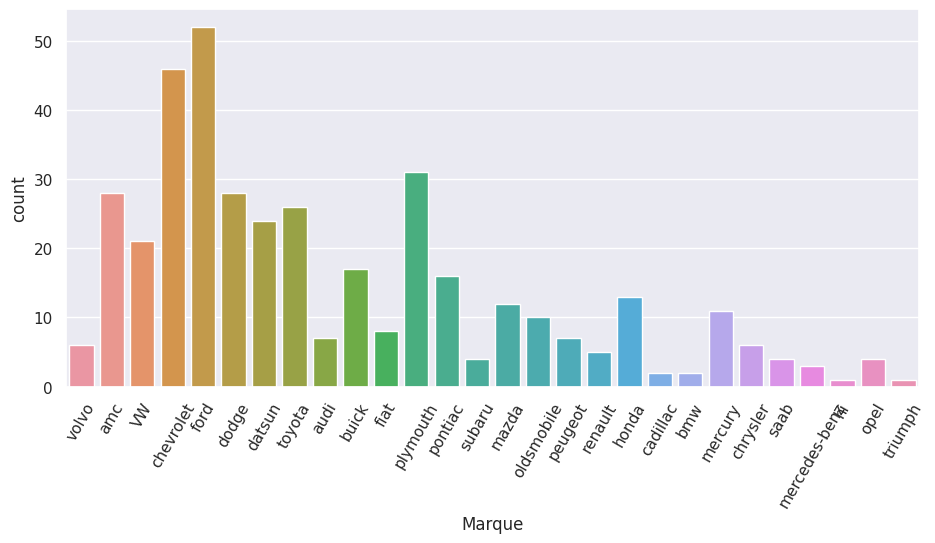

In [337]:
fig, ax = plt.subplots(figsize=(11, 5))
sns.countplot(car_data['Marque'])
plt.xticks(rotation=60)
plt.show()

Mapping des individus avec une classe de consommation

In [346]:
car_data.loc[(car_data.mpg < 18),'Classe']=1
car_data.loc[((car_data.mpg < 24) & (car_data.mpg >= 18)),'Classe']=2
car_data.loc[((car_data.mpg >= 24) & (car_data.mpg < 30)),'Classe']=3
car_data.loc[(car_data.mpg >= 30),'Classe']=4


In [347]:
# on verifie que tous les vehicules ont ete mappés
car_data.loc[((car_data.Classe != 1) & (car_data.Classe !=2) & (car_data.Classe !=3) & (car_data.Classe !=4) ), :]
car_data.Classe.unique()

array([2., 1., 4., 3.])

In [348]:

# Pour comparer plusieurs attributs numériques entre eux (ici engine, horsepower, acceleration, weight, mpg) il convient de les mettre à la même échelle
# fct de normalisation 
def scale(a):
    b = (a-a.min())/(a.max()-a.min())
    return b
car_data_scale = car_data.copy()
car_data_scale ['engine'] = scale(car_data_scale['engine'])
car_data_scale['horsepower'] = scale(car_data_scale['horsepower'])
car_data_scale ['acceleration'] = scale(car_data_scale['acceleration'])
car_data_scale ['weight'] = scale(car_data_scale['weight'])
car_data_scale['mpg'] = scale(car_data_scale['mpg'])


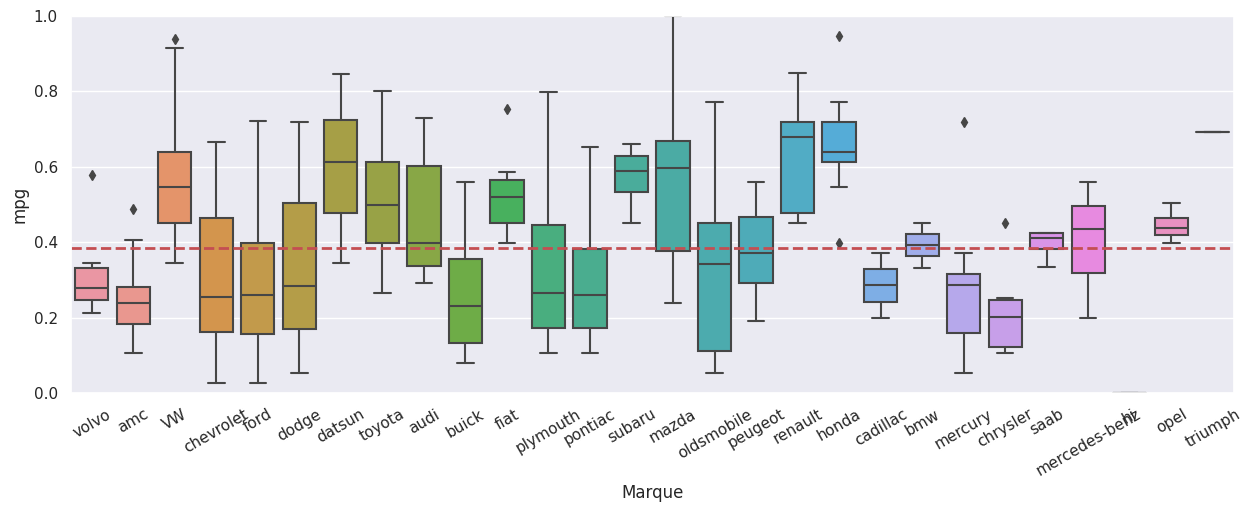

In [350]:
# Distribution mpg selon marque du constructeur
var = 'Marque'
data_plt = pd.concat([car_data_scale['mpg'], car_data[var]], axis=1)
f, ax = plt.subplots(figsize=(15,5))
fig = sns.boxplot(x=var, y="mpg", data=data_plt)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1)
plt.axhline(car_data_scale.mpg.mean(),color='r',linestyle='dashed',linewidth=2)

## Etape n°3 - Choix et construction du modèle



Etude des corrélations :
Celle-ci est nécessaire pour le choix du modèle, aussi cette partie pourrait aussi avoir sa place à l'étape n°1, mais le nettoyage des données pourrait impacter certaines corrélations.
Idéalement il y aurait une étape n°2 bis pour la distinguer du choix effectif du modèle. 

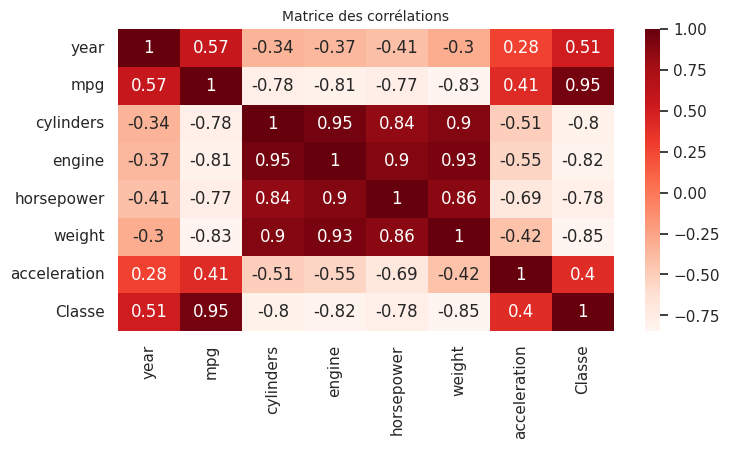

In [351]:
# Etude des corrélations
sns.set()

# mat des corrélations 
plt.figure(figsize=(8,4))
sns.heatmap(car_data_scale.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Matrice des corrélations',
         fontsize=10)
plt.show()

# on voit une corrélation forte entre engine et cylinders, ainsi qu'entre horsepower et cylinders et weight/cylinders, mais aussi entre horsepower/engine, weight/engine, et weight/horsepower. 


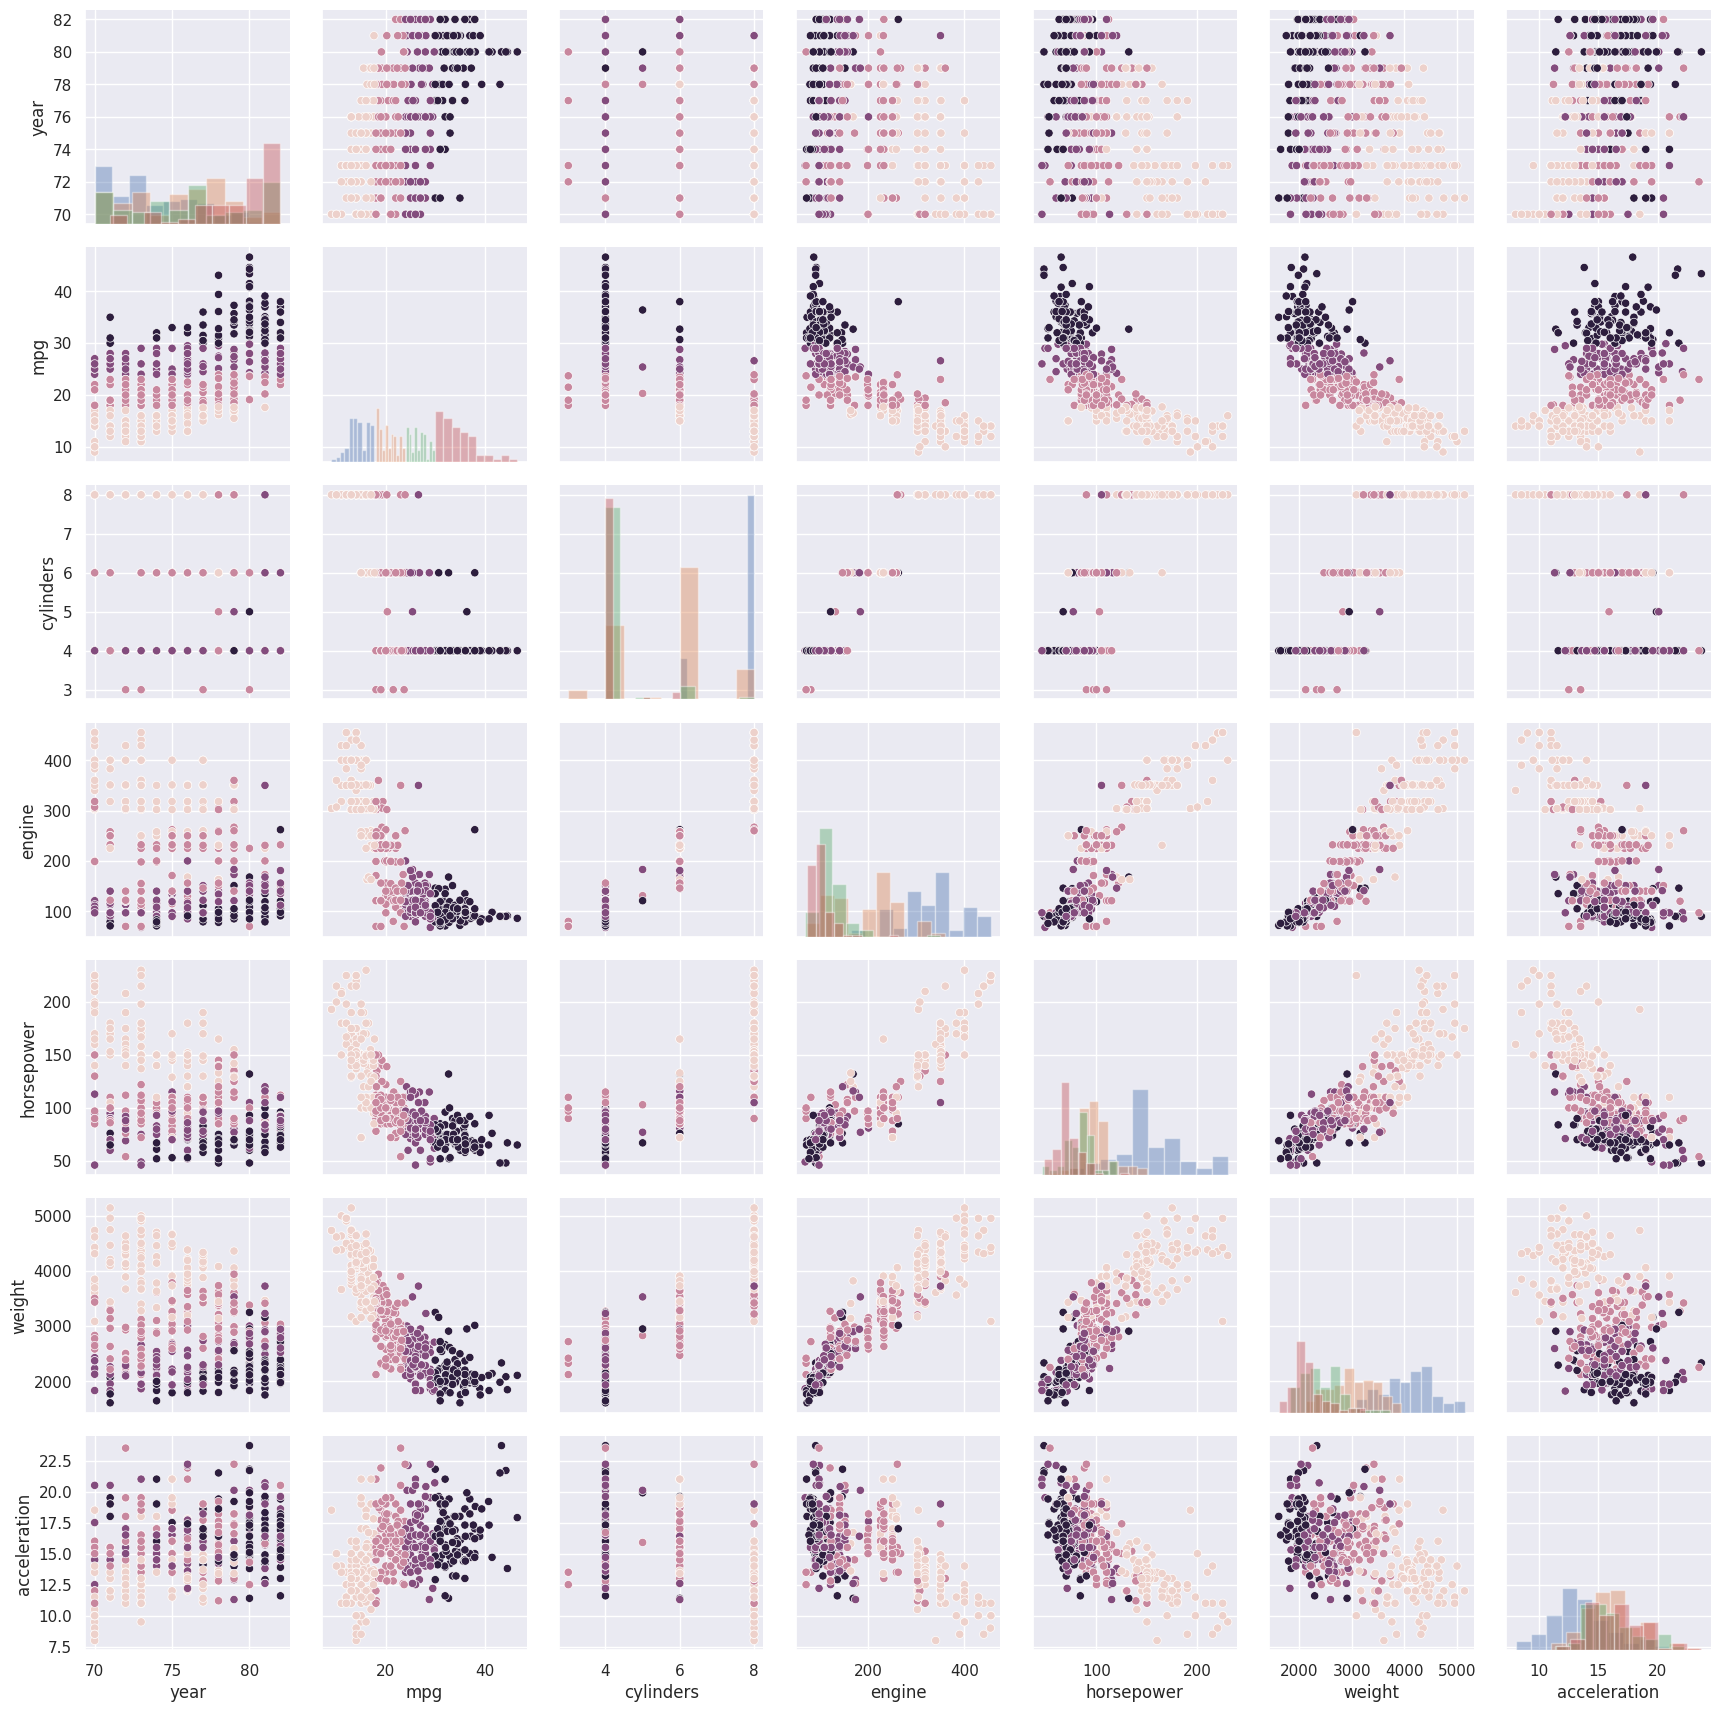

In [352]:
# par couple d'attributs, avec différentes teintes selon la classe de l'individu 
g = sns.PairGrid(car_data, hue='Classe')
g = g.map_diag(plt.hist, alpha=0.4) # Code couleur pr la classe : bleu = 1, orange = 2, vert = 3, rose = 4
g = g.map_upper(sns.scatterplot) # Code couleur pr la classe : beige = 1 ; rose = 2; violet = 3, violet noirâtre = 4
g = g.map_lower(sns.scatterplot)

In [ ]:
# nous pouvons observer :
#- la puissance et le poids ont une corrélation négative avec le moteur a une corrélation très moins positive ou presque nulle avec le mpg
#- l'accélération a une corrélation légèrement positive avec mpg
#- la cylindrée est positivement corrélée à la puissance, au poids
#- la puissance a une corrélation positive avec le poids et une corrélation négative avec l'accélération
#- le poids a très peu ou pas de corrélation avec l'accélération
#  ---> Ainsi, l'observation entre mpg et d'autres attributs indique que la relation n'est pas vraiment linéaire. 
# Néanmoins, la teinte par classe met en évidence des lignes de partage entre des groupements d'individus. Les frontières séparant les classes ont des allures de droite. 
# Nous pourrons ainsi envisager un algorithme de régression. Celui ne sera pas linéaire car la variable à prédire n'est pas continue, mais logistique multinomiale car la 
# variable à prédire (= la classe) est catégorielle. 


In [354]:
# pour faciliter l'utilisation des modèles, on mappe l'origine des véhicules à un entier
car_data2 = car_data
car_data2.loc[(car_data2.origin == 'European'),'origin']='1'
car_data2.loc[(car_data2.origin == 'American'),'origin']='2'
car_data2.loc[(car_data2.origin == 'Japanese'),'origin']='3'

Modèle de régression logistique multinomiale

In [376]:
# REGRESSION LOGISTIQUE MULTINOMIALE
#
# Justification : 
# Comme expliqué en début de paragraphe, la teinte par classe sur les pairplot a mis en évidence des lignes de partage entre 
# des groupements d'individus. Les frontières séparant les classes ont des allures de droite, ce qui nous conforte dans le choix
# d'un algorithme de régression. 
# Aussi, contrairement à ce que son nom pourrait laisser croire, la régression logistique est un algorithme de classification.  
# Nous utiliserons une logistique multinomiale car la variable à prédire (= la classe) est catégorielle. 

# On retire la marque de la prédiction car le string ne convient pas à l'algo de construction de l'arbre de décision
X = car_data2.drop(['Classe', 'Marque'],axis=1)     # Définition des prédicteurs (input du modèle)
y = car_data2.Classe                    # Définition de la variable à prédire (sortie du modèle)

# the feature/independent variables are not of the same scale so we scale them 
# scaling the feature variables ensures fast computing.
X_scaled = preprocessing.scale(X)  #PAs UTILE !!

# preprocessing.scale() returns a 2-d array not a DataFrame so we make our scaled variables
# a DataFrame.
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

# split our data into training and testing data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=1)

# création du modèle
model = LogisticRegression(solver='newton-cg', multi_class='multinomial')  # initialize the multinomial logistict regression model
model.fit(X_train,y_train)  # we fit the model with the training data

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [377]:
logistic_pred = model.predict(X_test)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(model.score(X_train,y_train)))
# score the model on the test set
print('Test score: {}\n'.format(model.score(X_test,y_test)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test,logistic_pred)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,logistic_pred)))

Train score: 0.9145569620253164

Test score: 0.8607594936708861

Overall model accuracy: 0.8909113733366809

Mean Squared Error: 0.13924050632911392


Modèle d'arbre de classification

In [378]:
# Construction des modèles : détermination des attributs prédictifs et de l'attribut dont il faut prédire les valeurs
# On retire la marque de la prédiction car le string ne convient pas à l'algo de construction de l'arbre de décision
all_inputs = car_data2.drop(['Classe', 'Marque'],axis=1)  # create a DataFrame of feature/independent variables
# Similarly, we can extract the classes
all_classes =  car_data2.Classe   # create a series of the dependent variable
# Here's what a subset of our inputs looks like:
all_inputs


,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
name,,,,,,,,
volvo 245,1,76,20.0,4,130.0,102.0,3150,15.7
amc matador,2,76,15.5,8,304.0,120.0,3962,13.9
amc hornet sportabout (sw),2,71,18.0,6,258.0,110.0,2962,13.5
amc hornet,2,73,18.0,6,232.0,100.0,2945,16.0
vw dasher (diesel),1,80,43.4,4,90.0,48.0,2335,23.7
...,...,...,...,...,...,...,...,...
subaru,3,74,26.0,4,108.0,93.0,2391,15.5
toyota corolla 1600 (sw),3,72,27.0,4,97.0,88.0,2100,16.5
oldsmobile cutlass ls,2,81,26.6,8,350.0,105.0,3725,19.0


In [364]:
#normalisation adéquate pr le modèle (pas nécessaire pr les arbres)
all_inputs_scaled = preprocessing.scale(all_inputs)

# partage du jeu de données en un jeu d'entraînement et un jeu de test. Le découpage est aléatoire et différent à chaque exécution
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs_scaled, all_classes, train_size=0.7, random_state=1)

In [369]:
# MODELE ARBRE DE DECISION (Classification Tree)

# Justification : 
# Les arbres de classification (Classification Tree) permettent de prédire à partir d'autres variables dites explicatives, 
# à quelle classe la variable-cible appartient, dans ce cas la prédiction est une étiquette de classe. 
# Ici nous cherchons à prédire à quelle classe appartient un véhicule, la situation semble parfaitement se prêter à l'application d'un tel modèle. 

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
print('Accuracy : ', decision_tree_classifier.score(testing_inputs, testing_classes))

Accuracy :  1.0


<AxesSubplot:ylabel='Density'>

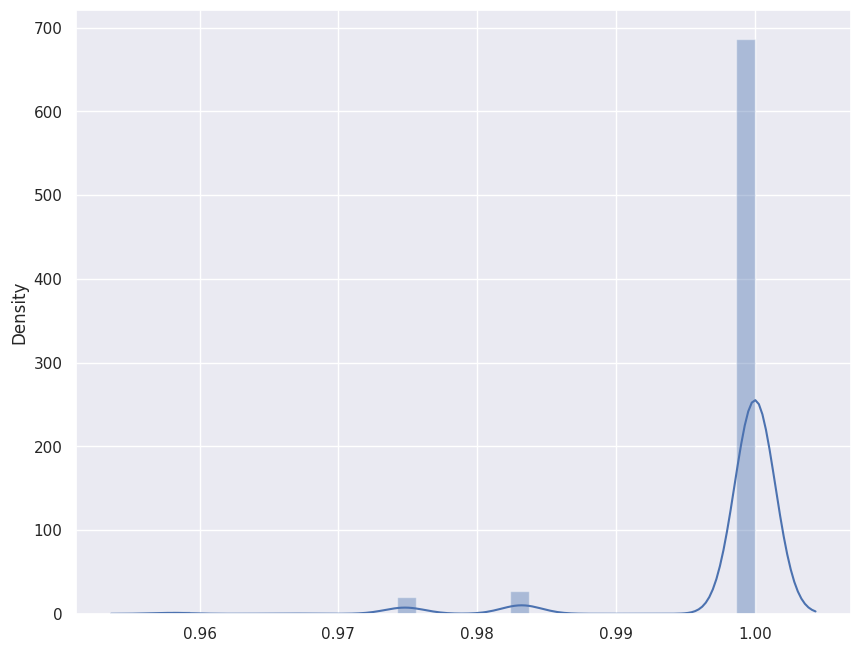

In [370]:
# on observe la variabilité de l'accuracy sur 1000 exécutions du modèle
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.7)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sns.distplot(model_accuracies)

In [ ]:
# L'accuracy semble optimal d'emblée ici, mais il est tout à fait possible que notre modèle soit bloqué 
# dans un phénomène de surapprentissage, courant pour les modèles d'arbre de classification (c'est un algorithme glouton où l'optimum est recherché localement et non globalement). 
# Nous pouvons alors "jouer" sur la taille du jeu de test au "détriment" du jeu d'entraînement (l'accuracy variera davantage avec train_size légèrement plus faible)
# Nous pouvons "supprimer" de l'information en ré exécutant le modèle avec un nombre d'attributs plus faible : 
# Dans ce cas nous ôterions les attributs qui possèdent une multi-colinéarité forte (voir fonctions VIF - Variance Inflation Factor)


## Etape n°4 - Evaluation et validation



Validation Croisée à k-blocs : "K-Fold"

Text(0.5, 1.0, 'Average score: 1.0')

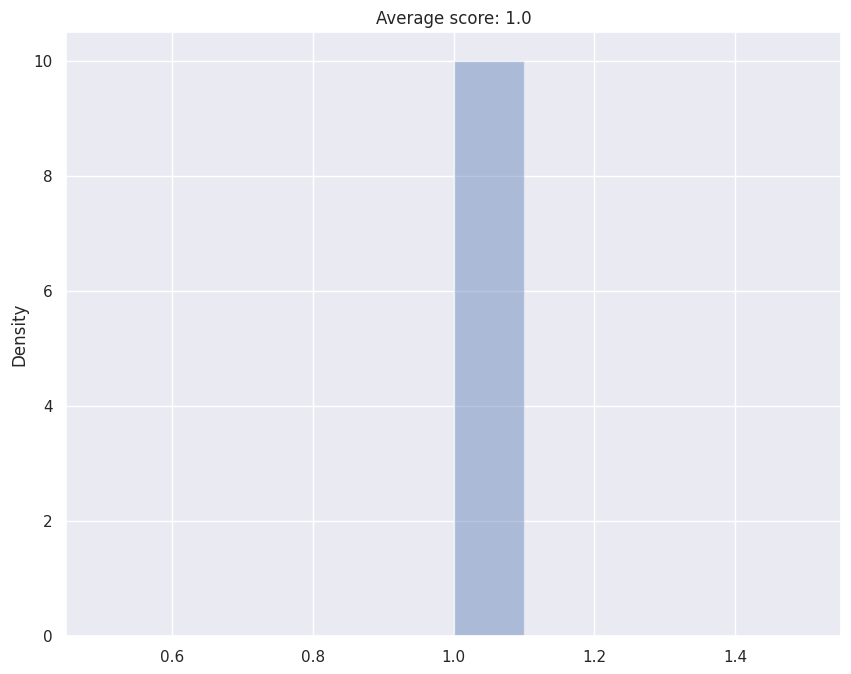

In [379]:
# Justification 
# On va s'assurer que les scores obtenus ci-dessus ne sont pas le fruit du hasard, nous allons donc 
# construire des jeux de validation à partir de notre jeu de données de départ : 
# (source wikipedia) : 
# on divise l'échantillon original en k échantillons  puis on sélectionne un des k  échantillons comme ensemble de validation pendant 
# que les k − 1 autres échantillons constituent l'ensemble d'apprentissage. Après apprentissage, on peut calculer une performance de validation. 
# Puis on répète l'opération en sélectionnant un autre échantillon de validation parmi les blocs prédéfinis. 
# À l'issue de la procédure nous obtenons ainsi k scores de performances, un par bloc.

from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=100)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Affinement des paramètres

Text(0.5, 1.0, 'Average score: 0.5408333333333333')

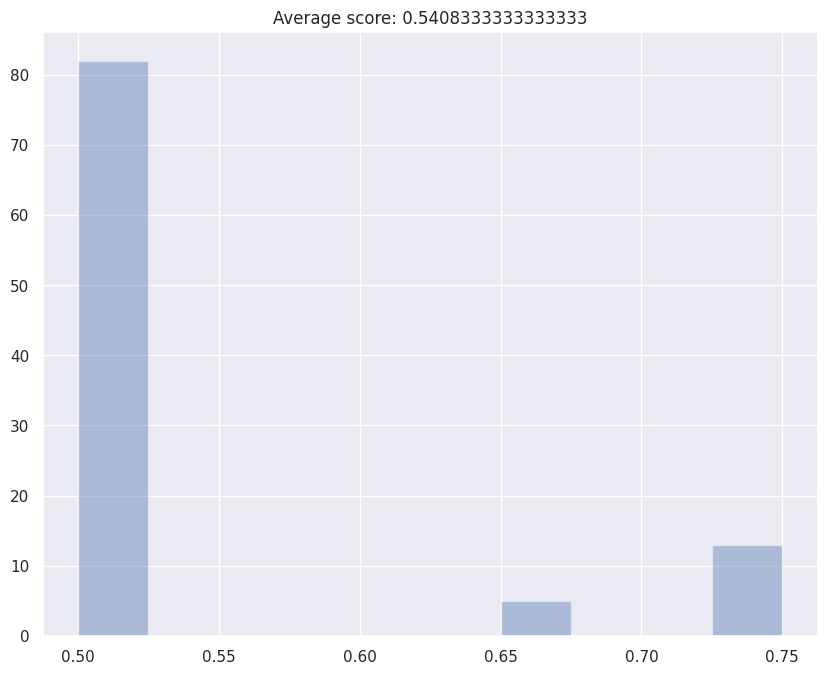

In [393]:
# L'accuracy ne laisse peu de place à un affinement supplémentaire
# Néanmoins, pour l'exercice, nous allons limiter la profondeur de l'arbre à 1
# ce qui devrait largement impacter négativement la performance de notre modèle

# on limite la profondeur à 1
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

# on observe les résultats de notre modèle de classification (par validation croisée de 100 blocs)
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=100)
sns.distplot(cv_scores, kde=False)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
# nous constatons en effet un plongeon de notre performance à 54% environ et en moyenne. 

In [396]:
# Pour l'exercice, nous allons utiliser la méthode Grid Search pour déterminer la combinaison des paramètres
# aboutissant à la meilleure des performances de l'arbre.
# Pour ce faire, Grid Search va tester le modèle sur toutes les combinaisons possibles de paramètres
decision_tree_classifier = DecisionTreeClassifier()

# nous étudions les combinaisons de paramètres suivantes
# !!! pour l'exercice, nous nous limitons volontairement à un nb max d'attributs et 
# à une profondeur max de l'arbre très peu élevée, de manière à laisser un peu
# de marge/opportunité à l'accuracy de s'améliorer  !!!
parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3],
                  'max_features': [1, 2, 3]}

cross_validation = skf.get_n_splits(all_classes)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8609615384615384
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'splitter': 'best'}


In [397]:
# Le meilleur score obtenu, compte tenu des contraintes que nous avons posé, est 86.1%
# nous utilisons les paramètres détectés comme la combinaison la plus performante pour former
# à nouveau notre modèle "optimal"
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=3)

<AxesSubplot:>

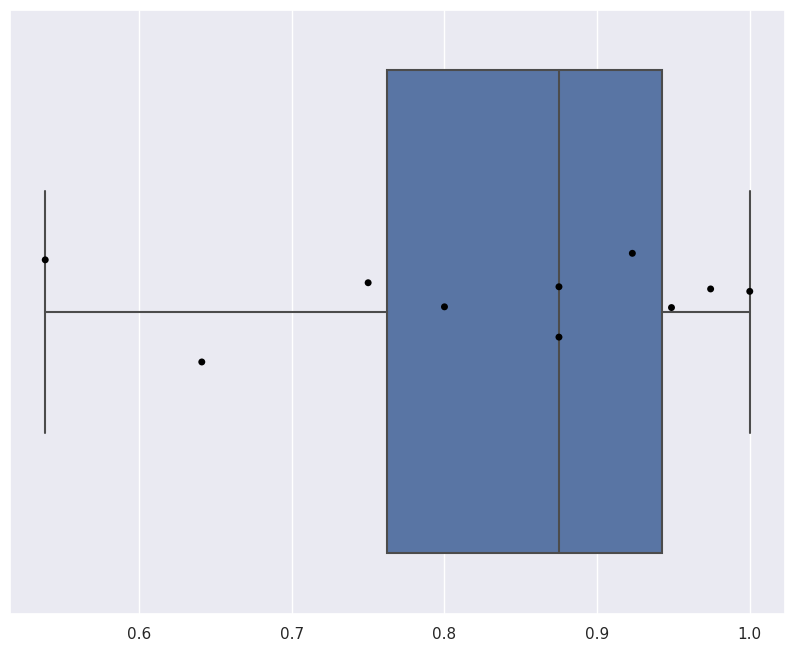

In [398]:
# Regardons les performances de notre modèle dont les paramètres ont été choisi de 
# manière optimale sous les contraintes posées dans paramater_grid
dt_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10)

sns.boxplot(dt_scores)
sns.stripplot(dt_scores, jitter=True, color='black')

In [ ]:
# Comme discuté précedemment, le plus gros défaut des arbres de classification est l'effet glouton
# Par la recherche d'un optimum local à chaque noeud, l'optimum global peut laisser à désirer, et
# ceci se constate dès lors que l'on introduit des nouveaux jeux de données

# Pour pallier partiellement à ce souci, nous pouvons entraîner toute une série d'arbres sur des 
# jeux fixés aléatoirement (pour chacun), et la combinaison de ces arbres permettra globalement
# une meilleure classification. Utilisons le Random Forrest. 

In [399]:
# MODELE Random Forrest Classifier

from sklearn.ensemble import RandomForestClassifier

# on réapplique le même procédé

random_forest_classifier = RandomForestClassifier()

# voici nos paramètres limitants dont nous allons tester la combinaison optimale
parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, ],
                  'warm_start': [True, False]}

cross_validation = skf.get_n_splits(all_classes)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 1.0
Best parameters: {'criterion': 'entropy', 'max_features': 3, 'n_estimators': 25, 'warm_start': True}


RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=25,
                       warm_start=True)

Tout seul, on va plus vite, mais à 2 (ou 3, ou 4... autant qu'il y a d'arbres dans la forêt), on va plus loin !


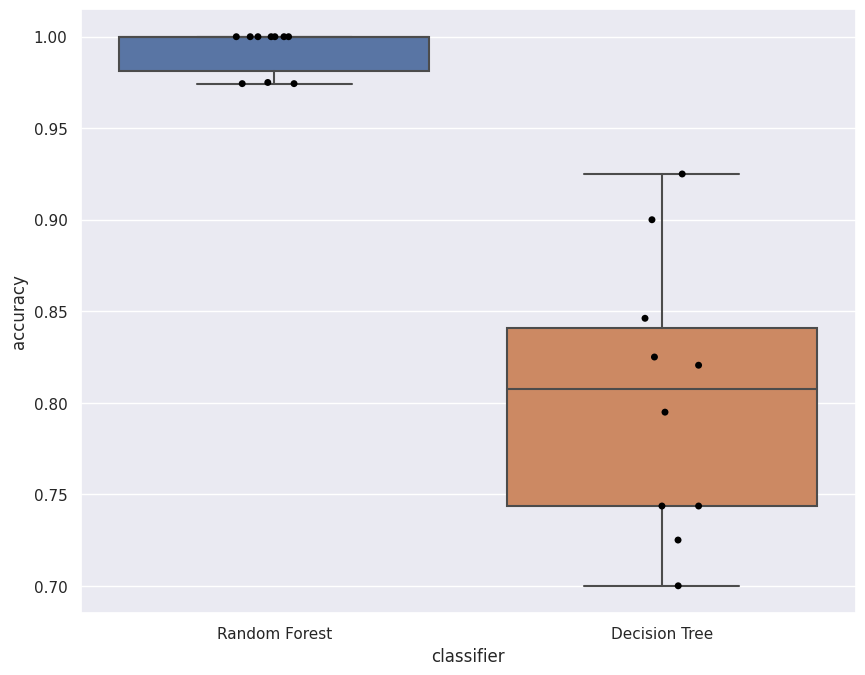

In [402]:
# nous appliquons notre random forrest avec les paramètres otpimaux trouvés ci-dessus
random_forest_classifier = grid_search.best_estimator_

# nous pouvons comparer nos deux modèles aux paramètres otpimisés : 
rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sns.boxplot(x='classifier', y='accuracy', data=both_df)
sns.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')

# le random forrest permet clairement de faire grimper l'accuracy : 
# d'où l'adage....
print("Tout seul, on va plus vite, mais à 2 (ou 3, ou 4... autant qu'il y a d'arbres dans la forêt), on va plus loin !")

# Etape finale : reproductibilité

In [ ]:
# Il convient de vérifier que tout le travail réalisé jusque-là puisse être reproductible 
# Ou alors, nous avons travaillé pour rien...
# Nous répétons les étapes précédentes sur le modèle élu

origin	-->	3.0	(Actual: 2.0)
year	-->	2.0	(Actual: 2.0)
mpg	-->	4.0	(Actual: 4.0)
cylinders	-->	2.0	(Actual: 2.0)
engine	-->	4.0	(Actual: 4.0)
horsepower	-->	2.0	(Actual: 2.0)
weight	-->	4.0	(Actual: 4.0)
acceleration	-->	1.0	(Actual: 1.0)


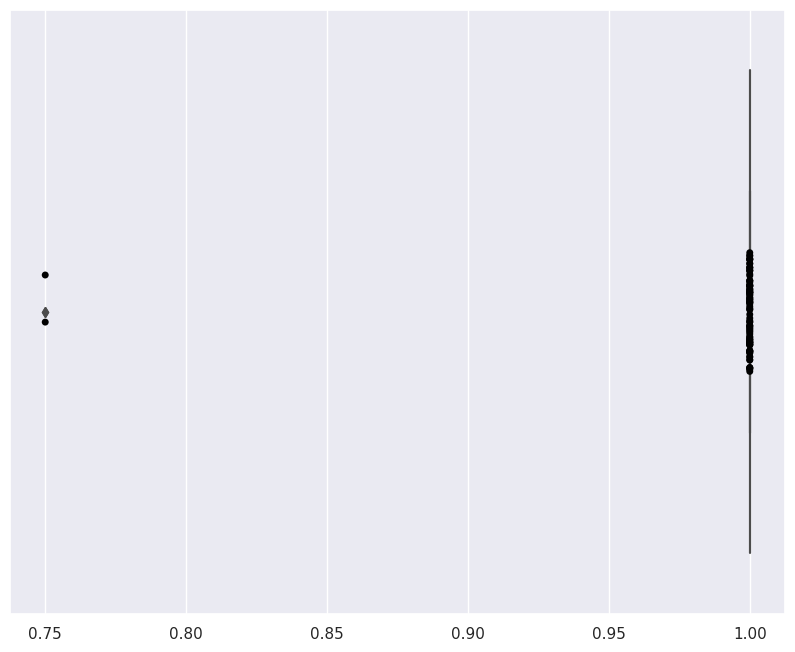

In [406]:
all_inputs = car_data2.drop(['Classe', 'Marque'],axis=1)  # create a DataFrame of feature/independent variables
# Similarly, we can extract the classes
all_classes =  car_data2.Classe 

# This is the classifier that came out of Grid Search
random_forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                max_depth=None, max_features=3, max_leaf_nodes=None,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
                                oob_score=False, random_state=1, verbose=0, warm_start=True)

# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=100)
sns.boxplot(rf_classifier_scores)
sns.stripplot(rf_classifier_scores, jitter=True, color='black')

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.7)

random_forest_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))